# Διπλωματική Εργασία
## Ταξινόμηση του καρκίνου του μαστού με μηχανική μάθηση

> Λάζαρος Πανιτσίδης<br />
> Τμήμα Μηχανικών Παραγωγής και Διοίκησης <br />
> Διεθνές Πανεπιστήμιο της Ελλάδος <br />
> lazarospanitsidis@outlook.com

## Περιεχόμενα
1. [Χρήσιμες βιβλιοθήκες](#1)
1. [Περιεχόμενα δεδομένων](#2)
1. [Ανάλυση των δεδομένων](#3)
1. [Οπτικοποίηση](#4)
1. [Επιλογή χαρακτηριστικών και έλεγχος με τυχαία δάση](#5)
    1. [Επιλογή χαρακτηριστικών με συσχέτιση](#6)
    1. [Μονομεταβλητή επιλογή χαρακτηριστικών (SelectKbest)](#7)
    1. [Αναδρομική εξάλειψη χαρακτηριστικών (RFE)](#8)
    1. [Αναδρομική εξάλειψη χαρακτηριστικών με διασταυρούμενη επικύρωση (RFECV)](#9)
    1. [Επιλογή χαρακτηριστικών βάσει δέντρων](#10)
1. [Εξαγωγή χαρακτηριστικών με PCA](#11)
1. [Συμπεράσματα](#12)

<a id='1'></a>
## Χρήσιμες βιβλιοθήκες

In [96]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization library  
import scipy.stats as stats
import matplotlib.pyplot as plt
import time
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'
#import warnings library
import warnings
# ignore all warnings
warnings.filterwarnings('ignore')
# Any results you write to the current directory are saved as output.

from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFE, RFECV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score , make_scorer , classification_report
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

<a id='2'></a>
### Περιεχόμενα δεδομένων

1. **Αριθμός Ταυτότητας**
1. **Διάγνωση (Μ = κακοήθης, Β = καλοήθης)**
1. **ακτίνα (μέσος όρος αποστάσεων από το κέντρο σε σημεία της περιμέτρου)**
1. **υφή (τυπική απόκλιση τιμών κλίμακας του γκρι)**
1. **περίμετρος**
1. **περιοχή**
1. **ομαλότητα (τοπική διακύμανση στο μήκος της ακτίνας)**
1. **συμπαγής (περίμετρος^2 / εμβαδόν - 1,0)**
1. **κοιλότητα (σοβαρότητα κοίλων τμημάτων του περιγράμματος)**
1. **κοίλα σημεία (αριθμός κοίλων τμημάτων του περιγράμματος)**
1. **συμμετρία**
1. **φράκταλ διάσταση ("προσέγγιση ακτογραμμής" - 1)**
<br>
* Ο μέσος όρος, το τυπικό σφάλμα και το "χειρότερο" ή μεγαλύτερο (μέσος όρος των τριών μεγαλύτερων τιμών) αυτών των χαρακτηριστικών υπολογίστηκαν για κάθε εικόνα, με αποτέλεσμα 30 χαρακτηριστικά. Για παράδειγμα, το πεδίο 3 είναι η μέση ακτίνα, το πεδίο 13 είναι η ακτίνα SE, το πεδίο 23 είναι η χειρότερη ακτίνα.
* Όλες οι τιμές χαρακτηριστικών επανακωδικοποιούνται με τέσσερα σημαντικά ψηφία.
* Τιμές χαρακτηριστικών που λείπουν: καμία
* Κατηγορίες κατανομής: 357 καλοήθεις, 212 κακοήθεις


<a id='3'></a>
## Ανάλυση των δεδομένων

In [2]:
dataWISC = pd.read_csv('dataWisc.csv')
dataWISC

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


* Υπάρχουν 3 πράγματα που παρατηρούνται στο dataframe: 
1. Υπάρχει ένα αναγνωριστικό που δεν μπορεί να χρησιμοποιηθεί για ταξινόμηση 
2. Η διάγνωση είναι η ετικέτα της τάξης μας 
3. Unnamed: Το χαρακτηριστικό 32 περιλαμβάνει NaN, επομένως δεν χρειάζεται

In [3]:
dataWISC.drop(["id", "Unnamed: 32"], axis = 1, inplace = True)

* έλεγχος για τιμές NaN σε όλο το dataframe

In [4]:
dataWISC.isna().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [5]:
#Description of the dataset

#how many cases are included in the dataset
length = len(dataWISC)
#how many features are in the dataset
features = dataWISC.shape[1]-1 # - diagnosis

# Number of malignant cases
malignant = len(dataWISC[dataWISC['diagnosis']=='M'])

#Number of benign cases
benign = len(dataWISC[dataWISC['diagnosis']=='B'])

#Rate of malignant tumors over all cases
rate = (float(malignant)/(length))*100

print ("There are "+ str(len(dataWISC))+" cases in this dataset")
print ("There are {}".format(features)+" features in this dataset")
print ("There are {}".format(malignant)+" cases diagnosed as malignant tumor")
print ("There are {}".format(benign)+" cases diagnosed as benign tumor")
print ("The percentage of malignant cases is: {:.2f}%".format(rate))

There are 569 cases in this dataset
There are 30 features in this dataset
There are 212 cases diagnosed as malignant tumor
There are 357 cases diagnosed as benign tumor
The percentage of malignant cases is: 37.26%


* Το y περιέχει την διάγνωση και το x τα χαρακτηριστικά

In [6]:
y = dataWISC.diagnosis                          # M or B 
x = dataWISC.drop('diagnosis',axis = 1 )
x.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Number of Benign:  357
Number of Malignant :  212


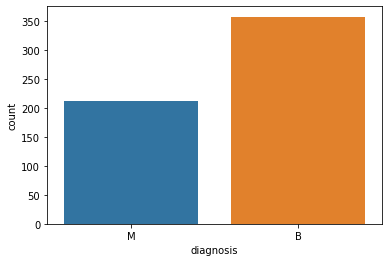

In [7]:
ax = sns.countplot(y,label="Count")       # M = 212, B = 357
B, M = y.value_counts()
print('Number of Benign: ',B)
print('Number of Malignant : ',M)

 * Δεν χρειάζεται να γνωρίζει κάποιος το νόημα αυτών των χαρακτηριστικών, ωστόσο θα πρέπει να γνωρίζει τιμές όπως η διακύμανση, η τυπική απόκλιση, ο αριθμός δειγμάτων (πλήθος) ή τις μέγιστες/ελάχιστες τιμές. Αυτού του είδους οι πληροφορίες βοηθούν στην κατανόηση του τι συμβαίνει στα δεδομένα.

In [8]:
x.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


<a id='4'></a>
## Οπτικοποίηση

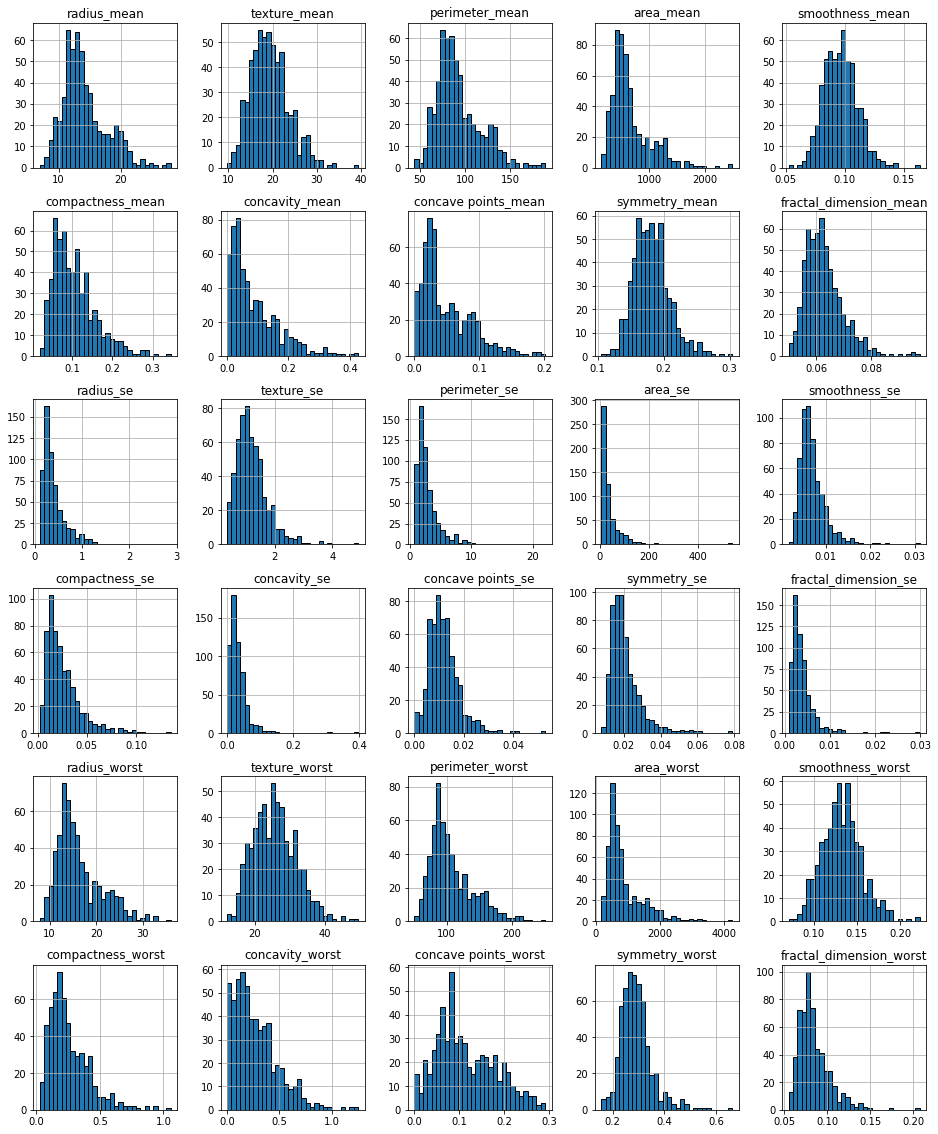

In [9]:
x.hist(figsize=(16, 20), bins=30, edgecolor="black")
plt.subplots_adjust()

* Πριν από τα γραφήματα του βιολιού και του σμήνους χρειάζεται κανονικοποίηση ή τυποποίηση, επειδή οι διαφορές μεταξύ των τιμών των χαρακτηριστικών είναι πολύ υψηλές για να παρατηρηθούν στα γραφήματα.

* Στην πράξη ο `StandardScaler` εκτελεί για κάθε στοιχείο $x$ την πράξη:

  $$ x' = \frac{x-\mu}{\sigma^2} $$
  
  όπου $\mu$ ο μέσος όρος της στήλης και $\sigma^2$ η διακύμανση της στήλης.

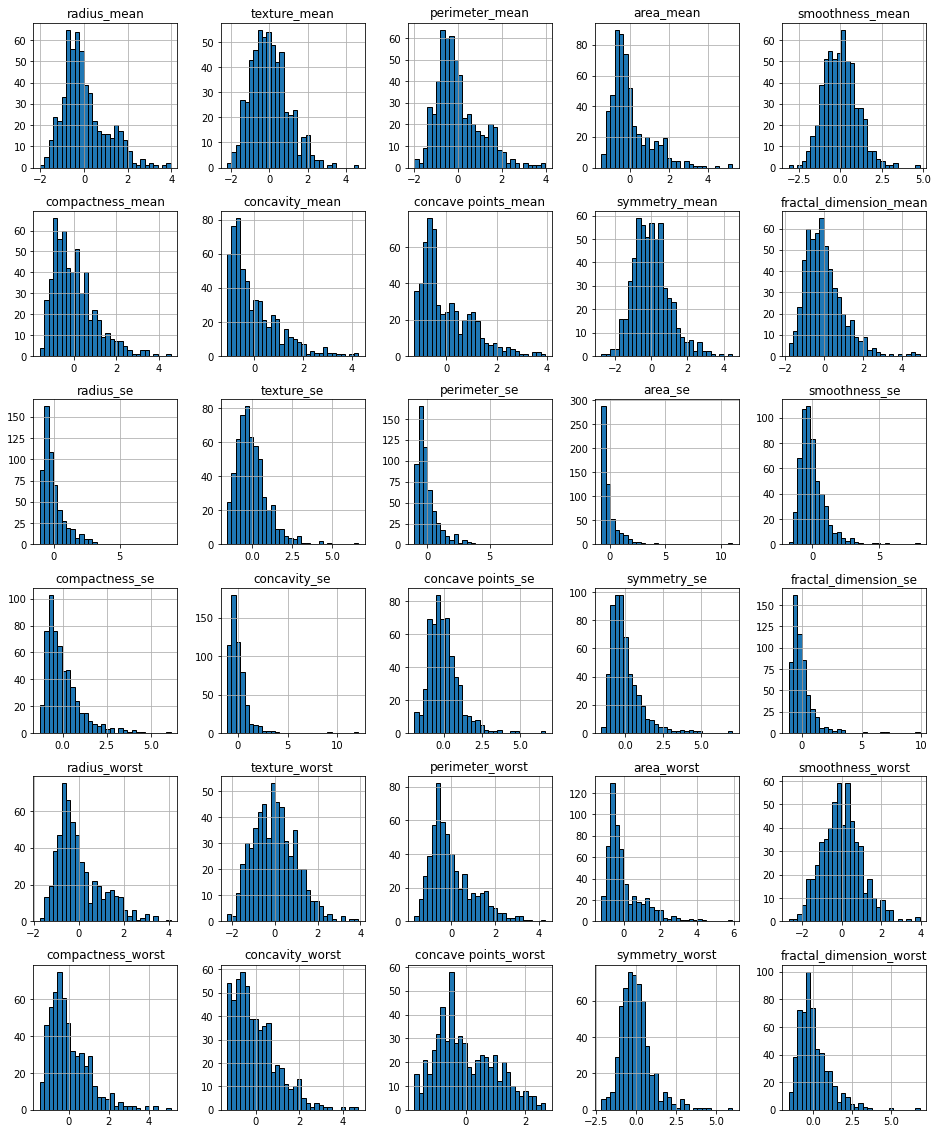

In [10]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()

# x_scaled=scaler.fit_transform(x)


# x_scaled = (x - x.min(axis=0)) / (x.max(axis=0)-x.min(axis=0))              # min max scale

x_scaled = (x - x.mean())/x.std()


x_scaled.hist(figsize=(16, 20), bins=30, edgecolor="black")
plt.subplots_adjust()

* Θα χρησιμοποιηθεί το seaborn προκειμένου να οπτικοποιηθούν τα δεδομένα και να δειχτεί η ποικιλομορφία των γραφημάτων.

* Από τα παρακάτω γραφήματα, αυτό που είναι χρήσιμο να παρατηρηθεί, είναι η διαχωρισημότητα της συνάρτησης πυκνότητας πιθανότητας μεταξύ των σημείων του καλοήθους και του κακοήθους καρκίνου για κάθε χαρακτηριστικό.

* Αυτή η διαχωρισιμότητα πρέπει να είναι όσο το δυνατό μεγαλύτερη, ώστε τα χαρακτηριστικά να παρέχουν καλές πληροφορίες για ταξινόμηση στα μοντέλα μηχανικής μάθησης που θα δημιουργηθούν στη συνέχεια.

* Τα χαρακτηριστικά σχεδιάζονται σε 3 ομάδες και κάθε ομάδα περιλαμβάνει 10 χαρακτηριστικά για να παρατηρηθούν ευκολότερα.

<AxesSubplot:xlabel='value', ylabel='features'>

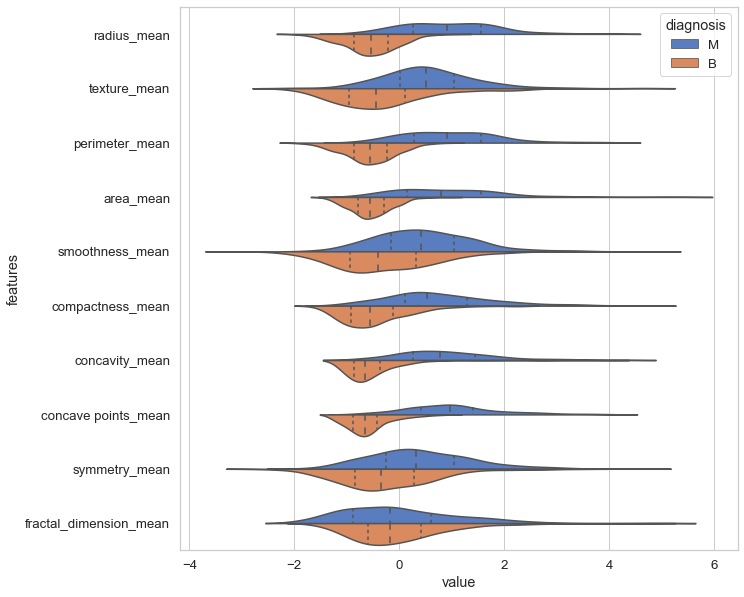

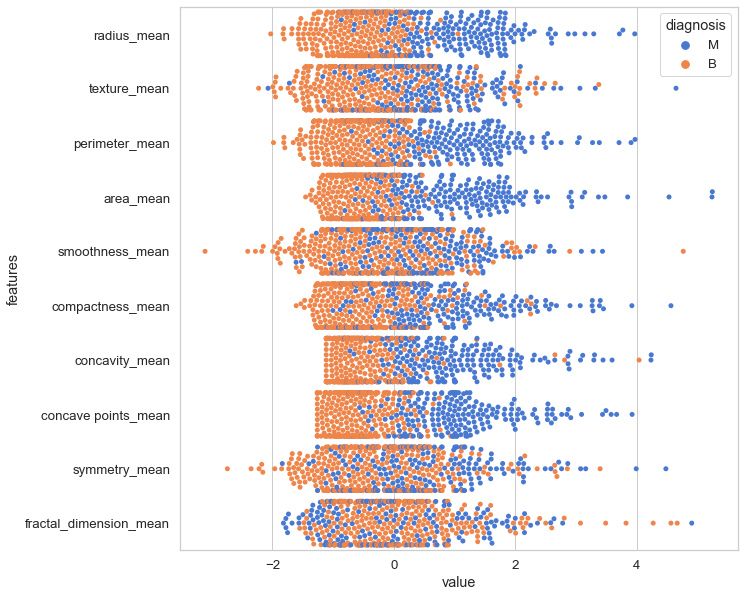

In [11]:
# first ten features
sns.set(style="whitegrid", palette="muted",font_scale = 1.2)
data = pd.concat([y,x_scaled.iloc[:,0:10]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="value", y="features", hue="diagnosis", data=data,split=True, inner="quart")
# plt.xticks(rotation=90)

# sns.set(style="whitegrid", palette="muted")
data = pd.concat([y,x_scaled.iloc[:,0:10]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
tic = time.time()
sns.swarmplot(x="value", y="features", hue="diagnosis", data=data)

<AxesSubplot:xlabel='value', ylabel='features'>

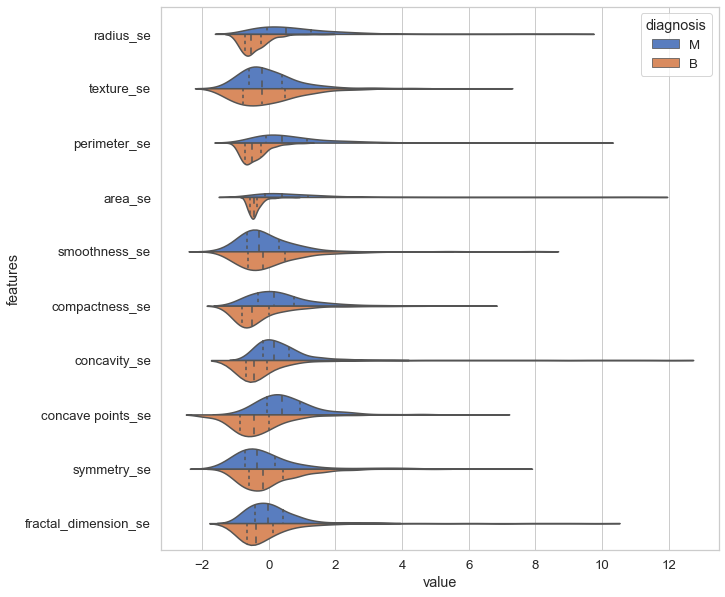

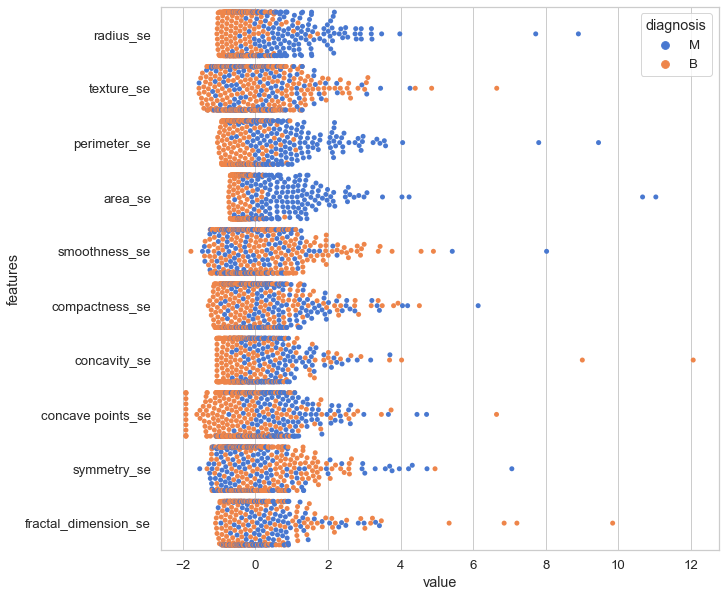

In [12]:
# Second ten features
data = pd.concat([y,x_scaled.iloc[:,10:20]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="value", y="features", hue="diagnosis", data=data,split=True, inner="quart")
# plt.xticks(rotation=90)

data = pd.concat([y,x_scaled.iloc[:,10:20]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.swarmplot(x="value", y="features", hue="diagnosis", data=data)
# plt.xticks(rotation=90)

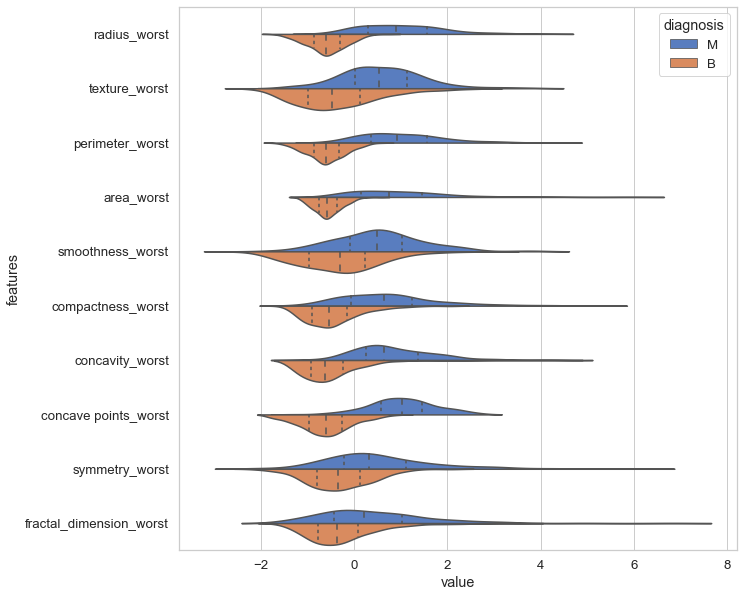

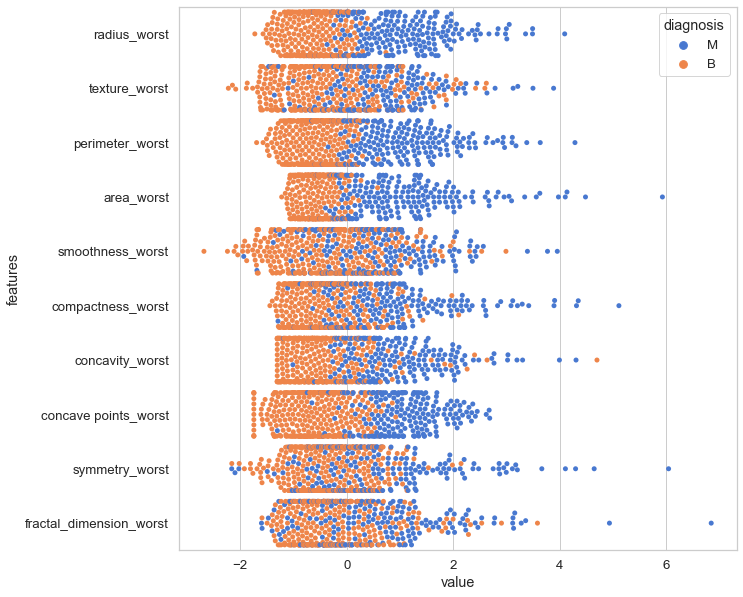

In [13]:
# Third ten features
data = pd.concat([y,x_scaled.iloc[:,20:30]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="value", y="features", hue="diagnosis", data=data,split=True, inner="quart")
# plt.xticks(rotation=90)


data = pd.concat([y,x_scaled.iloc[:,20:31]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.swarmplot(x="value", y="features", hue="diagnosis", data=data)
toc = time.time()
# plt.xticks(rotation=90)

* Στη συνέχεια πρέπει να διερευνηθεί η συσχέτιση (correlation) μεταξύ των χαρακτηστικών, ώστε να βρεθεί αν υπάρχει κάποιου είδους σχέση μεταξύ τους.
* Ένας συνήθης τρόπος μέτρησης της συσχέτισης είναι ο συντελεστής συσχέτισης Pearson (Pearson correlation coefficient). Ο συντελεστής αυτός, ο οποίος συμβολίζεται με $r$, είναι μια τιμή από το $-1$ στο $+1$.
* Η τιμή $+1$ δείχνει ότι οι μεταβλητές έχουν μια τέλεια θετική γραμμική σχέση, η τιμή $-1$ δείχνει μια τέλεια αρνητική γραμμική σχέση, ενώ η τιμή $0$ δείχνει ότι δεν υπάρχει γραμμική συσχέτιση.

* Εδώ για παράδειγμα, δείχνεται η συσχέτιση με συντελεστή pearson, μεταξύ του *concativity_worst* και του *concave points_worst*.

In [14]:
stats.pearsonr(x_scaled.loc[:,'concavity_worst'], x.loc[:,'concave points_worst'])

(0.8554338603439993, 3.7640977296930126e-164)

Text(-100, 0.46, 'p = 3.76e-164')

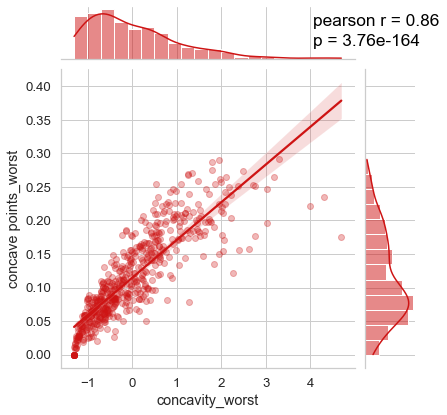

In [15]:
sns.jointplot(x_scaled.loc[:,'concavity_worst'], x.loc[:,'concave points_worst'], kind="reg", color="#ce1414",scatter_kws={'alpha':0.3})
# add text annotation
plt.text(-100, 0.49, "pearson r = 0.86", horizontalalignment='left', size='large', color='black')
plt.text(-100, 0.46, "p = 3.76e-164", horizontalalignment='left', size='large', color='black')

* Για να παρατηρηθεί η συσχέτιση μεταξύ όλων των χαρακτηριστικών, θα χρησιμοποιηθεί ο χάρτης θερμότητας.

* Όσα χαρακτηριστικά είναι τέλεια συσχετισμένα μεταξύ τους (*τιμή +1*), μπορούν να αφαιρεθούν διότι δεν χρησιμεύουν στην ταξινόμηση. Εκτός αυτού, πρόκειται να καταναλώσουν υπολογιστικούς πόρους από την εκπαίδευση των μοντέλων μηχανικής μάθησης.

Text(0.5, 1.0, 'Correlation Map')

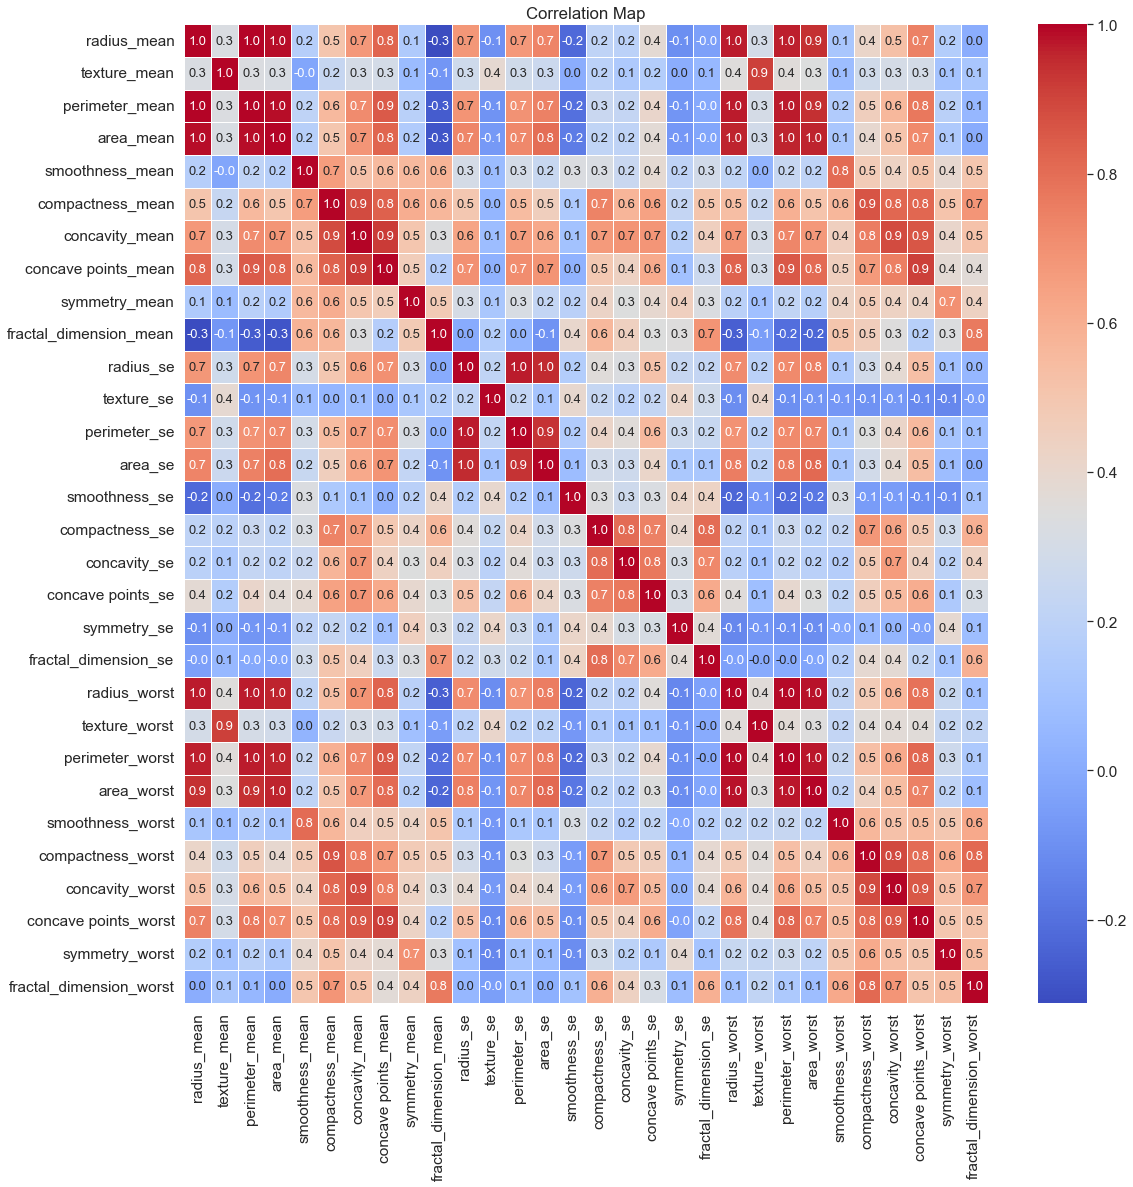

In [16]:
#correlation map
sns.set(font_scale = 1.4)
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(x_scaled.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax,cmap= 'coolwarm',annot_kws={'size': 13})
plt.title('Correlation Map')

In [70]:
target_names=['Benign','Malignant']

In [80]:
## ΜΕΘΟΔΟΣ ΑΛΕΞΑΝΔΡΟΥ ΓΙΑ CLASSIFICATION REPORT

originalclass = []
predictedclass = []

def classification_report_with_accuracy_score(y_true, y_pred):
  originalclass.extend(y_true)
  predictedclass.extend(y_pred)
  #print(classification_report(y_true, y_pred, target_names=target_names)) 
  return accuracy_score(y_true, y_pred) 
  
# Cross validate all features
clf_rf_0 = RandomForestClassifier(random_state=13)      
clr_rf_0 = clf_rf_0.fit(x_scaled,y)

score = cross_val_score(clf_rf_0, x_scaled, y, scoring=make_scorer(classification_report_with_accuracy_score))
print(classification_report(originalclass, predictedclass, target_names=target_names, digits=3))

              precision    recall  f1-score   support

      Benign      0.961     0.978     0.969       357
   Malignant      0.961     0.934     0.947       212

    accuracy                          0.961       569
   macro avg      0.961     0.956     0.958       569
weighted avg      0.961     0.961     0.961       569



In [91]:
## cross val
scores = cross_val_score(clr_rf_0, x_scaled, y, cv=5,scoring='f1_macro')
scores
print("F1 score is %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()*2))

F1 score is 0.958 (+/- 0.044)


<a id='5'></a>
## Επιλογή χαρακτηριστικών

* Σε αυτό το μέρος θα επιλεγούν χαρακτηριστικά με διαφορετικές μεθόδους και θα γίνεται **έλεγχος με τυχαία δάση**. Αυτές είναι η επιλογή χαρακτηριστικών με συσχέτιση, η μονομεταβλητή επιλογή χαρακτηριστικών, η αναδρομική εξάλειψη χαρακτηριστικών (RFE), η αναδρομική εξάλειψη χαρακτηριστικών με διασταυρούμενη επικύρωση (RFECV) και η επιλογή χαρακτηριστικών βάσει δέντρων. Θα χρησιμοποιηθεί η τυχαία ταξινόμηση δασών για να εκπαιδευθεί το μοντέλο και να προβλεφθεί η ακρίβεια.

<a id='6'></a>
### 1) Επιλογή χαρακτηριστικών με συσχέτιση

* Αφαιρούνται όσα χαρακτηριστικά έχουν συσχέτιση μεγαλύτερη του 0.8.

In [18]:
# Create correlation matrix
corr_matrix = x_scaled.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
correlated_features = [column for column in upper.columns if any(upper[column] > 0.8)]
x_1=x_scaled.drop(correlated_features, axis=1)
x_correlated_features = x_scaled[correlated_features]
print("Correlated features over 0.8 : ",correlated_features)

Correlated features over 0.8 :  ['perimeter_mean', 'area_mean', 'concavity_mean', 'concave points_mean', 'perimeter_se', 'area_se', 'concavity_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'fractal_dimension_worst']


Text(0.5, 1.0, 'Correlation Map')

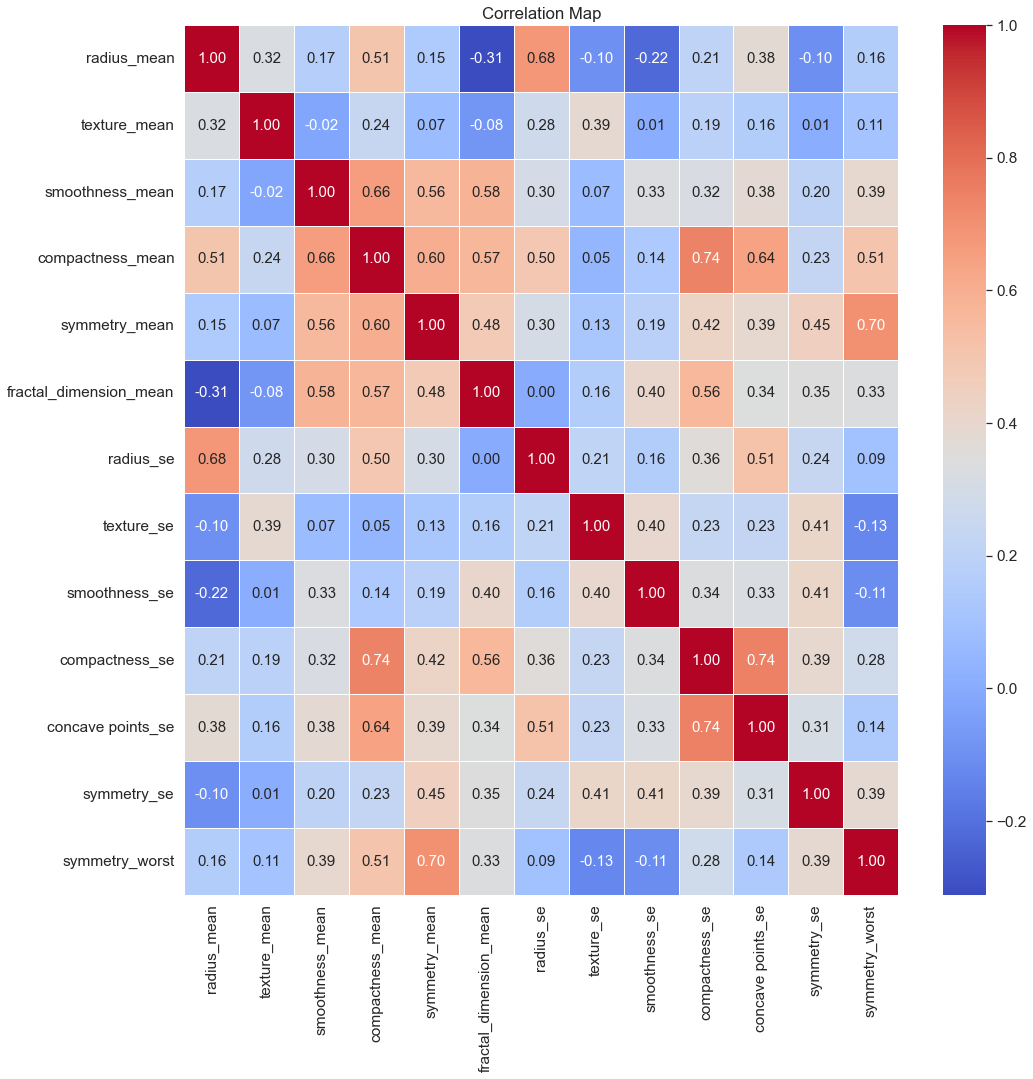

In [19]:
sns.set(font_scale = 1.4)
f,ax = plt.subplots(figsize=(16, 16))
sns.heatmap(x_1.corr(), annot=True, linewidths=.5, fmt= '.2f',ax=ax,cmap= 'coolwarm',annot_kws={'size': 15})
plt.title('Correlation Map')

* ΔΟΚΙΜΗ ΜΕ ΣΥΣΧΕΤΙΣΜΕΝΑ ΧΑΡΑΚΤΗΡΙΣΤΙΚΑ ΓΙΑ PCA

Text(0.5, 1.0, 'Correlation Map')

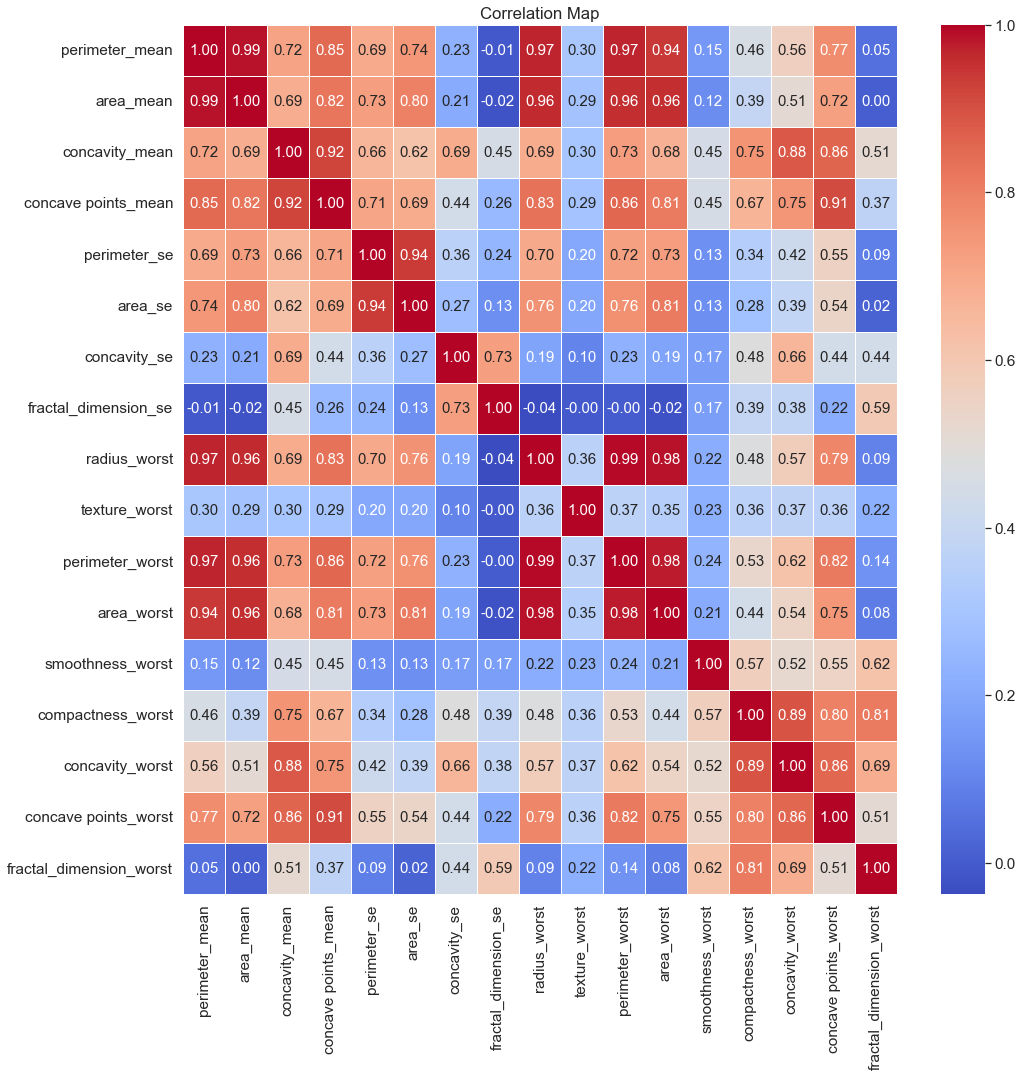

In [20]:
sns.set(font_scale = 1.4)
f,ax = plt.subplots(figsize=(16, 16))
sns.heatmap(x_correlated_features.corr(), annot=True, linewidths=.5, fmt= '.2f',ax=ax,cmap= 'coolwarm',annot_kws={'size': 15})
plt.title('Correlation Map')

Text(0, 0.5, 'explained_variance_ratio_')

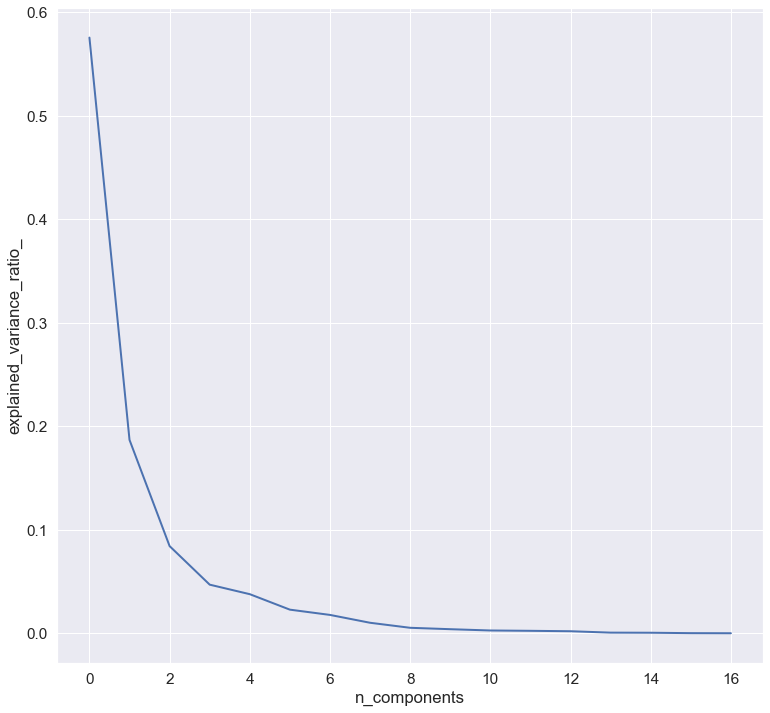

In [21]:
pca = PCA()
pca.fit(x_correlated_features)

plt.figure(1, figsize=(14, 13))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

In [22]:
pca = PCA(n_components=3)
pca.fit(x_correlated_features)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.57541505 0.18680853 0.08423262]
0.8464561982360743


In [23]:
# pca     = PCA(n_components=4).fit(x_scaled)
columns = ['pca_%i' % i for i in range(3)]
df_pca  = pd.DataFrame(pca.transform(x_correlated_features), columns=columns, index=x_correlated_features.index)
df_pca

,pca_0,pca_1,pca_2
0,7.550813,1.079929,0.862441
1,2.979842,-2.309283,-0.152235
2,4.845846,-0.585626,-0.126945
3,3.773580,6.964322,-1.662806
4,3.837024,-1.400013,1.622659
...,...,...,...
564,6.055926,-2.430611,1.329090
565,3.641755,-2.657977,-0.010530
566,1.360737,-0.598958,-0.011006
567,8.588010,2.510710,-1.316436


In [24]:
# df_pca_scaled = (df_pca - df_pca.min(axis=0)) / (df_pca.max(axis=0)-df_pca.min(axis=0)) 
df_pca_scaled = (df_pca - df_pca.mean())/df_pca.std()

In [25]:
x_all = x_1.join(df_pca_scaled)
x_all

,radius_mean,texture_mean,smoothness_mean,compactness_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,smoothness_se,compactness_se,concave points_se,symmetry_se,symmetry_worst,pca_0,pca_1,pca_2
0,1.096100,-2.071512,1.567087,3.280628,2.215566,2.253764,2.487545,-0.564768,-0.213814,1.315704,0.660239,1.147747,2.748204,2.414230,0.606000,0.720717
1,1.828212,-0.353322,-0.826235,-0.486643,0.001391,-0.867889,0.498816,-0.875473,-0.604819,-0.692317,0.259933,-0.804742,-0.243675,0.952748,-1.295849,-0.127218
2,1.578499,0.455786,0.941382,1.052000,0.938859,-0.397658,1.227596,-0.779398,-0.296744,0.814257,1.423575,0.236827,1.151242,1.549368,-0.328623,-0.106084
3,-0.768233,0.253509,3.280667,3.399917,2.864862,4.906602,0.326087,-0.110312,0.689095,2.741868,1.114027,4.728520,6.040726,1.206531,3.908013,-1.389559
4,1.748758,-1.150804,0.280125,0.538866,-0.009552,-0.561956,1.269426,-0.789549,1.481763,-0.048477,1.143199,-0.360775,-0.867590,1.226816,-0.785614,1.356009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,2.109139,0.720838,1.040926,0.218868,-0.312314,-0.930209,2.779634,0.070963,1.085429,0.191637,2.065360,-1.137415,-1.358963,1.936268,-1.363932,1.110682
565,1.703356,2.083301,0.102368,-0.017817,-0.217473,-1.057681,1.299356,2.258951,-0.423637,-0.069697,0.807720,-0.188995,-0.531387,1.164383,-1.491517,-0.008800
566,0.701667,2.043775,-0.839745,-0.038646,-0.808406,-0.894800,0.184730,-0.257145,-0.379008,0.660696,0.611619,-0.890632,-1.103578,0.435070,-0.336104,-0.009198
567,1.836725,2.334403,1.524426,3.269267,2.135315,1.042778,1.156917,0.685485,-0.172848,2.015943,0.785031,0.326346,1.917396,2.745854,1.408879,-1.100107


Text(0.5, 1.0, 'Correlation Map')

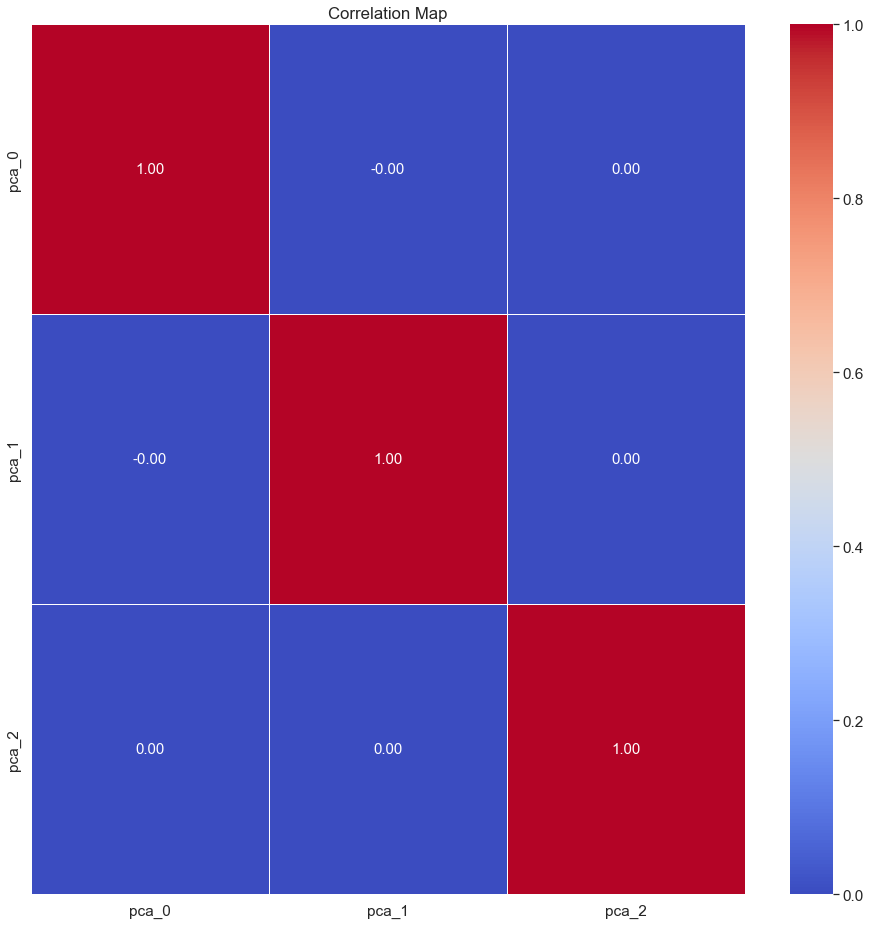

In [26]:
sns.set(font_scale = 1.4)
f,ax = plt.subplots(figsize=(16, 16))
sns.heatmap(df_pca.corr(), annot=True, linewidths=.5, fmt= '.2f',ax=ax,cmap= 'coolwarm',annot_kws={'size': 15})
plt.title('Correlation Map')

In [27]:
# corr_matrix = x_correlated_features.corr().abs()

# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# # Find index of feature columns with correlation greater than 0.95
# correlated_features = [column for column in upper.columns if any(upper[column] > 0.8)]
# x_correlated_features2 = x_correlated_features[correlated_features]
# print("Correlated features over 0.8 : ",correlated_features)

In [28]:
# sns.set(font_scale = 1.4)
# f,ax = plt.subplots(figsize=(16, 16))
# sns.heatmap(x_correlated_features2.corr(), annot=True, linewidths=.5, fmt= '.2f',ax=ax,cmap= 'coolwarm',annot_kws={'size': 15})
# plt.title('Correlation Map')

In [29]:
# corr_matrix = x_correlated_features2.corr().abs()

# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# # Find index of feature columns with correlation greater than 0.95
# correlated_features = [column for column in upper.columns if any(upper[column] > 0.8)]
# x_correlated_features3 = x_correlated_features[correlated_features]
# print("Correlated features over 0.8 : ",correlated_features)

In [30]:
# sns.set(font_scale = 1.4)
# f,ax = plt.subplots(figsize=(16, 16))
# sns.heatmap(x_correlated_features3.corr(), annot=True, linewidths=.5, fmt= '.2f',ax=ax,cmap= 'coolwarm',annot_kws={'size': 15})
# plt.title('Correlation Map')

* ΜΕΧΡΙ ΕΔΩ ΔΟΚΙΜΗ ΜΕ ΣΥΣΧΕΤΙΣΜΕΝΑ ΧΑΡΑΚΤΗΡΙΣΤΙΚΑ

Text(0.5, 1.0, 'Correlation Map')

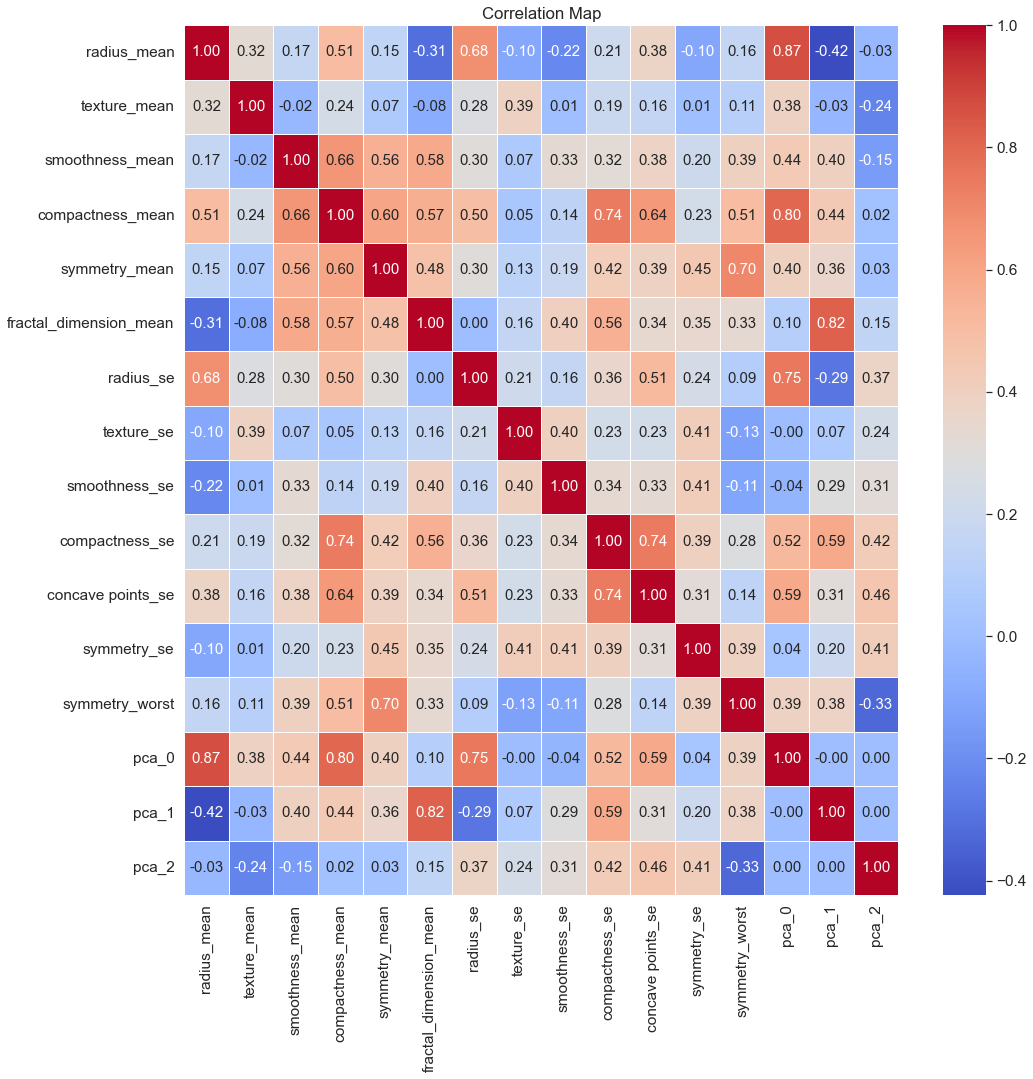

In [31]:
sns.set(font_scale = 1.4)
f,ax = plt.subplots(figsize=(16, 16))
sns.heatmap(x_all.corr(), annot=True, linewidths=.5, fmt= '.2f',ax=ax,cmap= 'coolwarm',annot_kws={'size': 15})
plt.title('Correlation Map')

* Γίνεται έλεγχος με χρήση τυχαίων δασών για να δειχτεί η ακρίβεια.

In [32]:
# split data train 80 % and test 20 %
x_train, x_test, y_train, y_test = train_test_split(x_all, y, test_size=0.2, random_state=42)

# x_train=x_all
# y_train=y
#random forest classifier with n_estimators=10 (default)
clf_rf = RandomForestClassifier(random_state=13)      
clr_rf = clf_rf.fit(x_train,y_train)

## cross val
scores = cross_val_score(clr_rf, x_train, y_train, cv=5,scoring='f1_macro')
scores


# ac = accuracy_score(y_test,clf_rf.predict(x_test))
# print('Accuracy is: ',ac)
# cm = confusion_matrix(y_test,clf_rf.predict(x_test))
# sns.heatmap(cm,annot=True,fmt="d")

array([0.94164422, 0.95180085, 0.98832884, 0.95245559, 0.96410256])

In [33]:
print("F1 score is %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()*2))

F1 score is 0.960 (+/- 0.032)


* Η ακρίβεια είναι σχεδόν 96.5% και όπως φαίνεται στον πίνακα σύγχυσης, γίνονται λίγες λανθασμένες προβλέψεις.

<a id='7'></a>
### 2) [Μονομεταβλητή επιλογή χαρακτηριστικών (SelectKbest)](<http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest>)

* Στην μονομεταβλητή επιλογή χαρακτηριστικών, θα χρησιμοποιήθεί το SelectKBest του sklearn που τα αφαιρεί όλα εκτός από τα k χαρακτηριστικά με την υψηλότερη βαθμολογία.

* Σε αυτή τη μέθοδο πρέπει να επιλεχτεί ο αριθμός των χαρακτηριστικών που θα χρησιμοποιηθούν. Για παράδειγμα, το k (αριθμός χαρακτηριστικών) θα είναι 5 ή 10 ή 15 και λοιπά. Δεν δοκιμάζονται όλοι οι συνδυασμοί, αλλά επιλέγεται μόνο k = 5 για τα 5 καλύτερα χαρακτηριστικά.

In [34]:
# find best scored 5 features
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=42)
select_feature = SelectKBest(f_classif, k=5).fit(x_train, y_train)

# Get columns to keep and create new dataframe with those only
cols = select_feature.get_support(indices=True)
x_train_2 = x_train.iloc[:,cols]
x_test_2 = x_test.iloc[:,cols]

In [35]:
print('Score list:', select_feature.scores_)
print('Feature list:', x_train.columns)
print('Selected feature list:', x_train_2.columns)

Score list: [4.82233945e+02 9.49177878e+01 7.41901474e+01 2.42589647e+02
 6.24695416e+01 9.27563953e-02 1.86591816e+02 4.71364906e-03
 1.53557408e+00 3.13387910e+01 7.65659230e+01 1.01038152e-02
 1.08953927e+02 8.09428046e+02 9.06808208e-01 2.69999574e+01]
Feature list: Index(['radius_mean', 'texture_mean', 'smoothness_mean', 'compactness_mean',
       'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se',
       'smoothness_se', 'compactness_se', 'concave points_se', 'symmetry_se',
       'symmetry_worst', 'pca_0', 'pca_1', 'pca_2'],
      dtype='object')
Selected feature list: Index(['radius_mean', 'compactness_mean', 'radius_se', 'symmetry_worst',
       'pca_0'],
      dtype='object')


* Τα καλύτερα 5 χαρακτηριστικά είναι τα **'radius_mean', 'texture_mean', 'compactness_mean', 'radius_se', 'symmetry_worst'**. Tώρα θα χρησιμοποιηθούν μόνο αυτά τα 5 χαρακτηριστικά για έλεγχο.

In [36]:
# x_train_2 = select_feature.transform(x_train)
# x_test_2 = select_feature.transform(x_test)
#random forest classifier with n_estimators=10 (default)
clf_rf_2 = RandomForestClassifier(random_state=13)      
clr_rf_2 = clf_rf_2.fit(x_train_2,y_train)

## cross val
scores = cross_val_score(clr_rf_2, x_train_2, y_train, cv=5,scoring='f1_macro')
scores
print("F1 score is %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()*2))

# ac_2 = accuracy_score(y_test,clf_rf_2.predict(x_test_2))
# print('Accuracy is: ',ac_2)
# cm_2 = confusion_matrix(y_test,clf_rf_2.predict(x_test_2))
# sns.heatmap(cm_2,annot=True,fmt="d")

F1 score is 0.938 (+/- 0.040)


* Η ακρίβεια είναι σχεδόν 94,7% και όπως φαίνεται στον πίνακα σύγχυσης, γίνονται περισσότερες λανθασμένες προβλέψεις από πριν. Παρόλο που χρησιμοποιούνται μόνο 5 χαρακτηριστικά στη μέθοδο SelectkBest, οι ακρίβειες είναι αρκετά κοντά.

<a id='8'></a>
### 3) [Αναδρομική εξάλειψη χαρακτηριστικών (RFE)](<http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html>)

* Βασικά, χρησιμοποιεί μία από τις μεθόδους ταξινόμησης (τυχαίο δάσος στο παράδειγμά μας), εκχωρεί βάρη σε καθένα από τα χαρακτηριστικά. Τα απόλυτα βάρη των οποίων είναι τα μικρότερα, αφαιρούνται από τα τρέχοντα χαρακτηριστικά του συνόλου. Αυτή η διαδικασία επαναλαμβάνεται αναδρομικά στο κλαδευμένο σύνολο μέχρι τον επιθυμητό αριθμό χαρακτηριστικών

NOTE: This algorithm assumes that none of the features are correlated. It is not advisable to use a feature if it has a Pearson
correlation coefficient of more than 0.8 with any other feature

In [37]:
# Create the RFE object and rank each pixel
clf_rf_3 = RandomForestClassifier(random_state=13)      
rfe = RFE(estimator=clf_rf_3, n_features_to_select=5, step=1)
rfe = rfe.fit(x_train, y_train)

In [38]:
print('Chosen best 5 feature by rfe:',x_train.columns[rfe.support_])

Chosen best 5 feature by rfe: Index(['radius_mean', 'compactness_mean', 'radius_se', 'pca_0', 'pca_2'], dtype='object')


* Τα 5 καλύτερα χαρακτηριστικά που επιλέχθηκαν από το `RFE` είναι τα **'radius_mean', 'compactness_mean', 'radius_se', 'smoothness_worst','symmetry_worst**.

In [39]:
x_train_3 = rfe.transform(x_train)
x_test_3 = rfe.transform(x_test)
#random forest classifier with n_estimators=10 (default)
clr_rf_3 = clf_rf_3.fit(x_train_3,y_train)

## cross val
scores = cross_val_score(clr_rf_3, x_train_3, y_train, cv=5,scoring='f1_macro')
scores
print("F1 score is %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()*2))

# ac_3 = accuracy_score(y_test,clf_rf_3.predict(x_test_3))
# print('Accuracy is: ',ac_3)
# cm_3 = confusion_matrix(y_test,clf_rf_3.predict(x_test_3))
# sns.heatmap(cm_3,annot=True,fmt="d")

F1 score is 0.948 (+/- 0.019)


<a id='9'></a>
### 4) [Αναδρομική εξάλειψη χαρακτηριστικών με διασταυρούμενη επικύρωση (RFECV)](<http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html>)

* Τώρα εκτός από τα καλύτερα χαρακτηριστικά θα βρεθεί επίσης και ο αριθμός αυτών για την καλύτερη ακρίβεια.

In [40]:
# The "accuracy" scoring is proportional to the number of correct classifications
clf_rf_4 = RandomForestClassifier(random_state=13)
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator=clf_rf_4,min_features_to_select=min_features_to_select, step=1, cv=5,scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(x_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', x_train.columns[rfecv.support_])

Optimal number of features : 12
Best features : Index(['radius_mean', 'texture_mean', 'smoothness_mean', 'compactness_mean',
       'fractal_dimension_mean', 'radius_se', 'compactness_se',
       'concave points_se', 'symmetry_worst', 'pca_0', 'pca_1', 'pca_2'],
      dtype='object')


* Τέλος, βρίσκουμε τα 7 καλύτερα χαρακτηριστικά που είναι **'radius_mean', 'texture_mean', 'compactness_mean', 'radius_se','concavity_se', 'smoothness_worst', 'symmetry_worst'**.

In [41]:
x_train_4 = rfecv.transform(x_train)
#x_test_4 = rfecv.transform(x_test)
#random forest classifier with n_estimators=10 (default)
clr_rf_4 = clf_rf_4.fit(x_train_4,y_train)

## cross val
scores = cross_val_score(clr_rf_4, x_train_4, y_train, cv=5,scoring='f1_macro')
scores
print("F1 score is %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()*2))

# ac_4 = accuracy_score(y_test,clf_rf_4.predict(x_test_4))
# print('Accuracy is: ',ac_4)
# cm_4 = confusion_matrix(y_test,clf_rf_4.predict(x_test_4))
# sns.heatmap(cm_4,annot=True,fmt="d")

F1 score is 0.962 (+/- 0.031)


* Η ακρίβεια είναι ίδια με την μέθοδο SelectKBest, παρόλο που χρησιμοποιούνται 2 παραπάνω χαρακτηριστικά.

Optimal number of features : 12


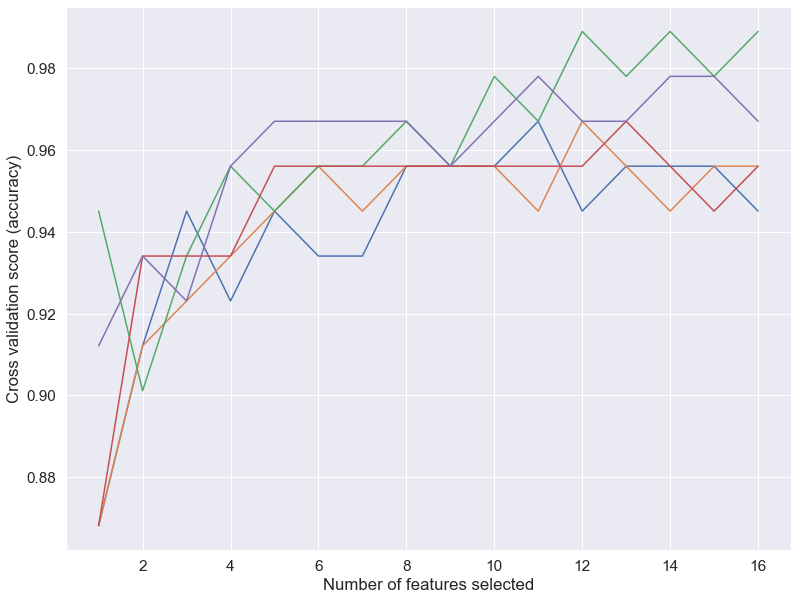

In [42]:
# Plot number of features VS. cross-validation scores
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(13,10))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

<a id='10'></a>
### 5) [Επιλογή χαρακτηριστικών βάσει δέντρων](<http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html>)

* Στη μέθοδο τυχαίας ταξινόμησης δασών υπάρχει ένα χαρακτηριστικό **feature_importances_** που είναι η σημασία των χαρακτηριστικών (όσο υψηλότερη, τόσο πιο σημαντική είναι η δυνατότητα). *!!! Για να χρησιμοποιηθεί η μέθοδος feature_importance, στα δεδομένα εκπαίδευσης δεν θα πρέπει να υπάρχουν συσχετισμένα χαρακτηριστικά. Το τυχαίο δάσος επιλέγει τυχαία σε κάθε επανάληψη, επομένως η σειρά της λίστας σημασίας χαρακτηριστικών μπορεί να αλλάξει.*

Feature ranking:
1. feature 13 (0.375263)
2. feature 0 (0.170257)
3. feature 3 (0.095885)
4. feature 15 (0.072087)
5. feature 6 (0.071700)
6. feature 1 (0.046732)
7. feature 12 (0.029880)
8. feature 2 (0.026193)
9. feature 10 (0.026047)
10. feature 14 (0.018207)
11. feature 9 (0.016695)
12. feature 5 (0.015435)
13. feature 8 (0.009759)
14. feature 11 (0.009034)
15. feature 7 (0.008519)
16. feature 4 (0.008309)


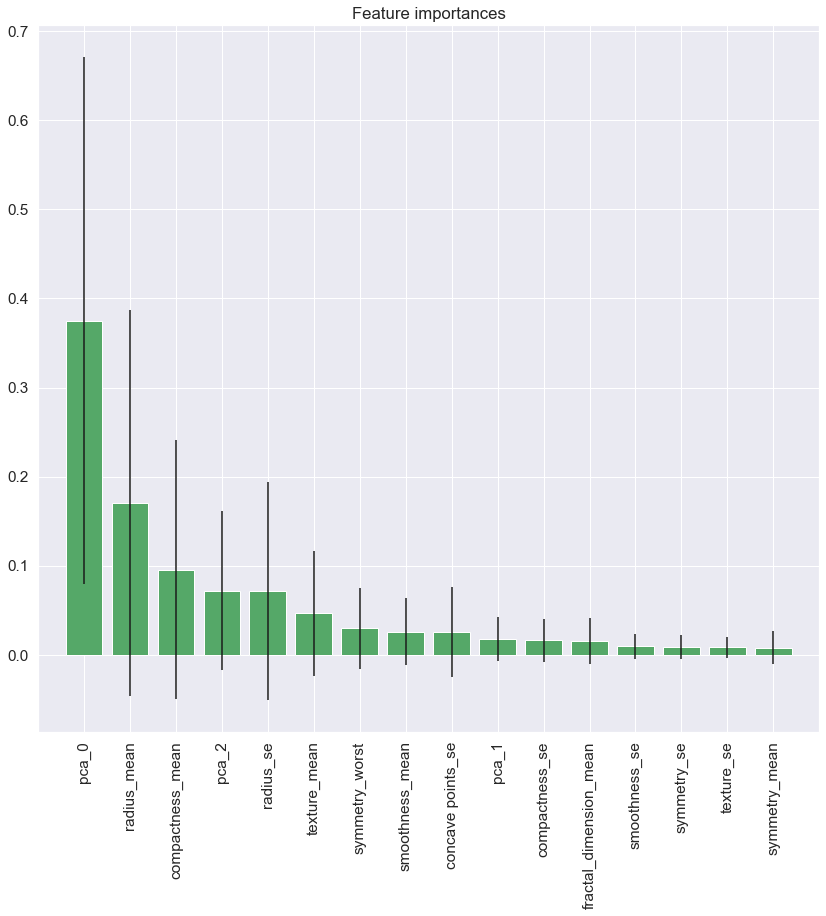

In [43]:
clf_rf_5 = RandomForestClassifier(random_state=13)      
clr_rf_5 = clf_rf_5.fit(x_train,y_train)
importances = clr_rf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest

plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), x_train.columns[indices],rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.show()

In [44]:
# # plot feature importance using built-in function
# from numpy import loadtxt
# from xgboost import XGBClassifier
# from xgboost import plot_importance
# from matplotlib import pyplot

# # fit model no training data
# model = XGBClassifier()
# model.fit(x, y)
# # plot feature importance
# plot_importance(model)
# pyplot.show()

<a id='11'></a>
## [Εξαγωγή χαρακτηριστικών με PCA](<http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html>)

* Θα χρησιμοποιηθεί η *Ανάλυση Κύριων Συνιστωσών* (Principal Component Analysis) για την εξαγωγή χαρακτηριστικών. Πριν από το PCA, πρέπει να κανονικοποιηθούν τα δεδομένα για την καλύτερη απόδοση του PCA.

In [45]:
from mrmr import mrmr_classif
y_mrmr = pd.Series(y)
selected_features = mrmr_classif(x_all, y_mrmr, K=8)
selected_features

100%|██████████| 8/8 [00:00<00:00, 80.81it/s]


['pca_0',
 'pca_2',
 'radius_mean',
 'compactness_mean',
 'radius_se',
 'texture_mean',
 'symmetry_worst',
 'concave points_se']

In [46]:
mrmr_train = x_all[selected_features]

Text(0.5, 1.0, 'Correlation Map')

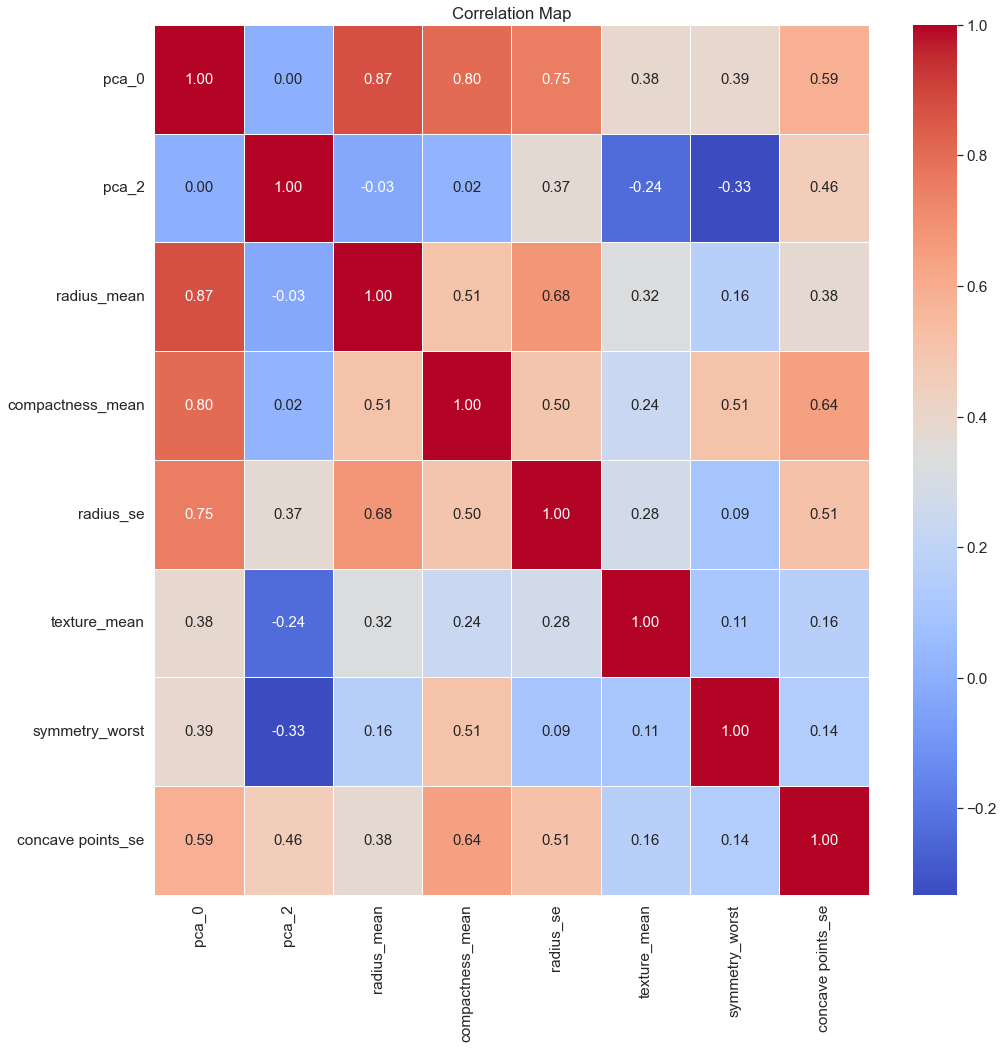

In [47]:
sns.set(font_scale = 1.4)
f,ax = plt.subplots(figsize=(16, 16))
sns.heatmap(mrmr_train.corr(), annot=True, linewidths=.5, fmt= '.2f',ax=ax,cmap= 'coolwarm',annot_kws={'size': 15})
plt.title('Correlation Map')

In [92]:
clf_rf_mrmr = RandomForestClassifier(random_state=13)
clr_rf_mrmr = clf_rf_mrmr.fit(mrmr_train,y)

## cross val
scores = cross_val_score(clr_rf_mrmr, mrmr_train, y, cv=5,scoring='f1_macro')
scores
print("F1 score is %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()*2))

F1 score is 0.949 (+/- 0.036)


In [95]:
originalclass = []
predictedclass = []

  
# Cross validate all features
# clf_rf_0 = RandomForestClassifier(random_state=13)      
# clr_rf_0 = clf_rf_0.fit(x_scaled,y)

score = cross_val_score(clf_rf_mrmr, mrmr_train, y, scoring=make_scorer(classification_report_with_accuracy_score))
print(classification_report(originalclass, predictedclass, target_names=target_names, digits=3))

              precision    recall  f1-score   support

      Benign      0.956     0.969     0.962       357
   Malignant      0.947     0.925     0.936       212

    accuracy                          0.953       569
   macro avg      0.951     0.947     0.949       569
weighted avg      0.952     0.953     0.952       569



Text(0, 0.5, 'explained_variance_ratio_')

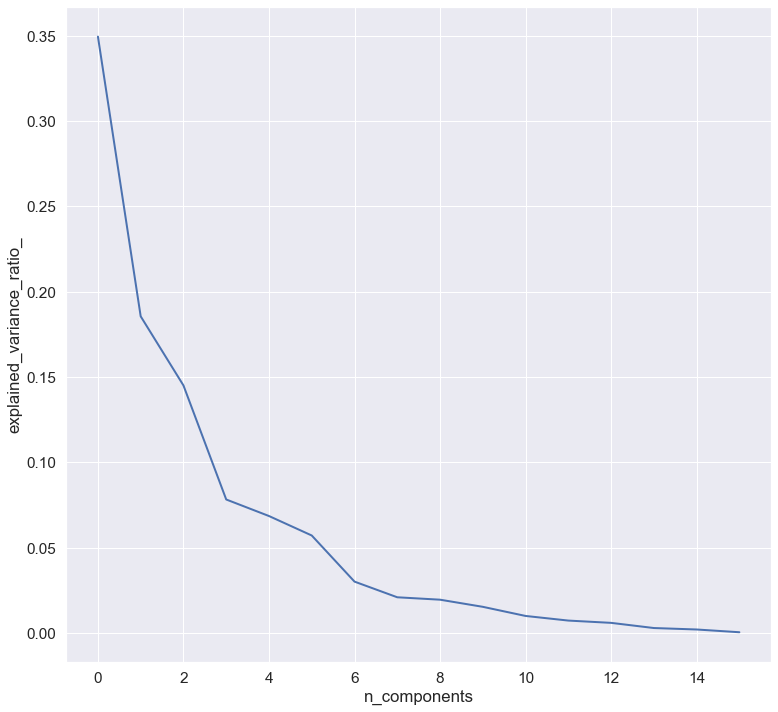

In [48]:
# split data train 80 % and test 20 %
x_train, x_test, y_train, y_test = train_test_split(x_all, y, test_size=0.2, random_state=42)
#normalization
# x_train_N = (x_train-x_train.mean())/(x_train.max()-x_train.min())
# x_test_N = (x_test-x_test.mean())/(x_test.max()-x_test.min())


# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# scaler.fit(x)
# x_train_N = scaler.transform(x_train)
# x_test_N = scaler.transform(x_test)

pca = PCA()
pca.fit(x_train)

plt.figure(1, figsize=(14, 13))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

* Σύμφωνα με την αναλογία διακύμανσης, μπορούν να επιλεγούν 3 συστατικά.

In [49]:
pca = PCA(n_components=6)
pca.fit(x_train)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.34944322 0.18559172 0.14511703 0.07832024 0.06863223 0.05723122]
0.8843356651262037


In [50]:
pca.components_

array([[ 0.13916307,  0.0993303 ,  0.27209671,  0.37142538,  0.30437067,
         0.27727387,  0.23745207,  0.12608969,  0.17117807,  0.36067124,
         0.33769398,  0.21056452,  0.21899104,  0.29142969,  0.22528208,
         0.12477433],
       [ 0.51995206,  0.20788157, -0.02378148,  0.10569457, -0.03046521,
        -0.35557965,  0.34510343, -0.09761421, -0.24303728, -0.09444002,
         0.0372232 , -0.16407599,  0.02177864,  0.38050442, -0.40479459,
        -0.115322  ],
       [ 0.01786302, -0.00904917, -0.22779918, -0.15802392, -0.19735165,
        -0.131055  ,  0.26297887,  0.30478083,  0.26823601,  0.12525305,
         0.20696095,  0.19631223, -0.42195341, -0.05645846, -0.21375443,
         0.55554412],
       [-0.09117194,  0.57846369, -0.05266818, -0.13211685,  0.15192831,
        -0.10181402, -0.0146048 ,  0.56813066,  0.12496307, -0.13960189,
        -0.16263149,  0.28605375,  0.18134401, -0.09173443, -0.08824497,
        -0.29654065],
       [ 0.00289678, -0.4285514 , -0

In [51]:
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

In [52]:
clf_rf_pca = RandomForestClassifier(random_state=13)
clr_rf_pca = clf_rf_pca.fit(x_train_pca,y_train)

## cross val
scores = cross_val_score(clr_rf_pca, x_train_pca, y_train, cv=5,scoring='f1_macro')
scores
print("F1 score is %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()*2))

# ac_pca = accuracy_score(y_test,clf_rf_pca.predict(x_test_pca))
# print('Accuracy is: ',ac_pca)
# cm_pca = confusion_matrix(y_test,clf_rf_pca.predict(x_test_pca))
# sns.heatmap(cm_pca,annot=True,fmt="d")

F1 score is 0.942 (+/- 0.063)


In [53]:
# from sklearn.metrics import classification_report

# print(classification_report(y_test, clf_rf_pca.predict(x_test_pca)))

* ΣΧΟΛΙΟ : Να κάνω pca στα χαρακτηρηστικα που εχουν μεγαλη συσχετιση και να τα βαλω πανω στους υπολογισμους των χαρακτηρηστικων και του accuracy. Πχ βγαζω 3 χαρακτηρηστικα απτα 16 που συσχετιζονται.. τα βαζω στο x_1 + 3 χαρακτηρηστικα που θα βγαλει το pca και συνεχιζω τη διαδικασία.

Text(0, 0.5, 'explained_variance_ratio_')

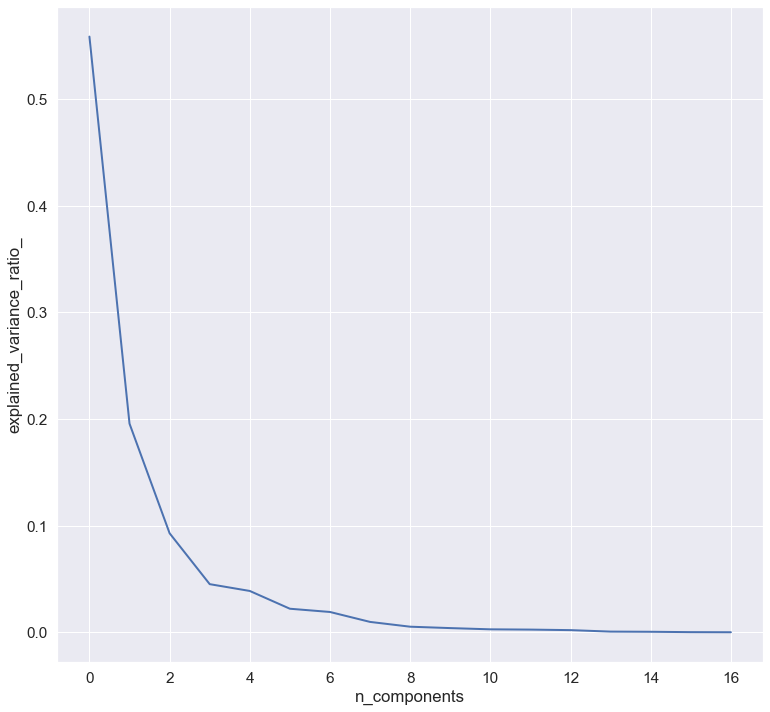

In [54]:
# split data train 80 % and test 20 %
x_train, x_test, y_train, y_test = train_test_split(x_correlated_features, y, test_size=0.2, random_state=42)
#normalization
# x_train_N = (x_train-x_train.mean())/(x_train.max()-x_train.min())
# x_test_N = (x_test-x_test.mean())/(x_test.max()-x_test.min())


# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# scaler.fit(x)
# x_train_N = scaler.transform(x_train)
# x_test_N = scaler.transform(x_test)


pca = PCA()
pca.fit(x_train)

plt.figure(1, figsize=(14, 13))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

In [55]:
pca = PCA(n_components=2)
pca.fit(x_train)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.55860362 0.19565541]
0.7542590254132356


Accuracy is:  0.9649122807017544


<AxesSubplot:>

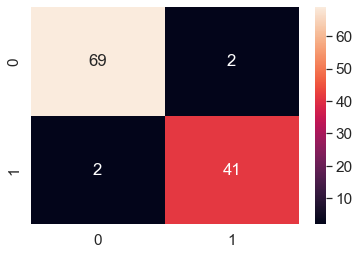

In [56]:
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

clf_rf_pca = RandomForestClassifier(random_state=13)
clr_rf_pca = clf_rf_pca.fit(x_train_pca,y_train)
ac_pca = accuracy_score(y_test,clf_rf_pca.predict(x_test_pca))
print('Accuracy is: ',ac_pca)
cm_pca = confusion_matrix(y_test,clf_rf_pca.predict(x_test_pca))
sns.heatmap(cm_pca,annot=True,fmt="d")

In [58]:
def corrX_new(df, cut = 0.8) :
       
    # Get correlation matrix and upper triagle
    corr_mtx = df.corr().abs()
    avg_corr = corr_mtx.mean(axis = 1)
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool))
    
    dropcols = list()
    
    res = pd.DataFrame(columns=(['v1', 'v2', 'v1.target', 
                                 'v2.target','corr', 'drop' ]))
    
    for row in range(len(up)-1):
        col_idx = row + 1
        for col in range (col_idx, len(up)):
            if(corr_mtx.iloc[row, col] > cut):
                if(avg_corr.iloc[row] > avg_corr.iloc[col]): 
                    dropcols.append(row)
                    drop = corr_mtx.columns[row]
                else: 
                    dropcols.append(col)
                    drop = corr_mtx.columns[col]
                
                s = pd.Series([ corr_mtx.index[row],
                up.columns[col],
                avg_corr[row],
                avg_corr[col],
                up.iloc[row,col],
                drop],
                index = res.columns)
        
                res = res.append(s, ignore_index = True)
    
    dropcols_names = calcDrop(res)
    
    return(dropcols_names)

In [59]:
def calcDrop(res):
    # All variables with correlation > cutoff
    all_corr_vars = list(set(res['v1'].tolist() + res['v2'].tolist()))
    
    # All unique variables in drop column
    poss_drop = list(set(res['drop'].tolist()))

    # Keep any variable not in drop column
    keep = list(set(all_corr_vars).difference(set(poss_drop)))
     
    # Drop any variables in same row as a keep variable
    p = res[ res['v1'].isin(keep)  | res['v2'].isin(keep) ][['v1', 'v2']]
    q = list(set(p['v1'].tolist() + p['v2'].tolist()))
    drop = (list(set(q).difference(set(keep))))

    # Remove drop variables from possible drop 
    poss_drop = list(set(poss_drop).difference(set(drop)))
    
    # subset res dataframe to include possible drop pairs
    m = res[ res['v1'].isin(poss_drop)  | res['v2'].isin(poss_drop) ][['v1', 'v2','drop']]
        
    # remove rows that are decided (drop), take set and add to drops
    more_drop = set(list(m[~m['v1'].isin(drop) & ~m['v2'].isin(drop)]['drop']))
    for item in more_drop:
        drop.append(item)
         
    return drop

In [60]:
drop_new = corrX_new(x_scaled, cut = 0.8)
print(len(drop_new))
drop_new


15


['texture_worst',
 'area_worst',
 'area_mean',
 'compactness_worst',
 'radius_se',
 'smoothness_mean',
 'compactness_se',
 'perimeter_se',
 'perimeter_mean',
 'radius_worst',
 'compactness_mean',
 'perimeter_worst',
 'concave points_worst',
 'concavity_mean',
 'concave points_mean']

In [61]:
list(set(x_correlated_features).difference(set(drop_new)))

['smoothness_worst',
 'fractal_dimension_se',
 'concavity_se',
 'area_se',
 'fractal_dimension_worst',
 'concavity_worst']

In [62]:
x_dokimh=x_scaled.drop(drop_new, axis=1)
x_drop_new = x_scaled[drop_new]
print("Correlated features over 0.8 : ",drop_new)

Correlated features over 0.8 :  ['texture_worst', 'area_worst', 'area_mean', 'compactness_worst', 'radius_se', 'smoothness_mean', 'compactness_se', 'perimeter_se', 'perimeter_mean', 'radius_worst', 'compactness_mean', 'perimeter_worst', 'concave points_worst', 'concavity_mean', 'concave points_mean']


Text(0.5, 1.0, 'Correlation Map')

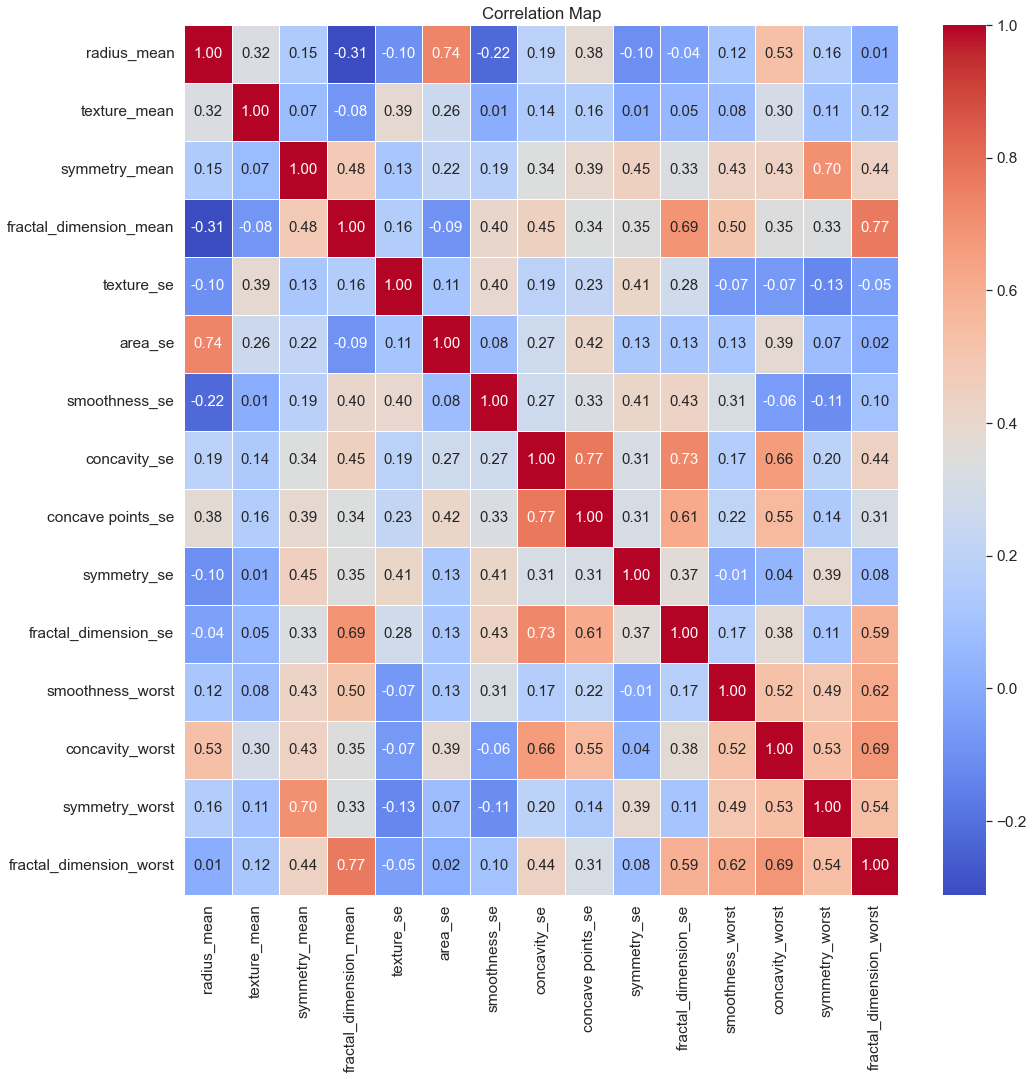

In [63]:
sns.set(font_scale = 1.4)
f,ax = plt.subplots(figsize=(16, 16))
sns.heatmap(x_dokimh.corr(), annot=True, linewidths=.5, fmt= '.2f',ax=ax,cmap= 'coolwarm',annot_kws={'size': 15})
plt.title('Correlation Map')